<center>

### COSC2753 - Machine Learning

# **Model Development - Residual Network (ResNet)**

<center>────────────────────────────</center>
&nbsp;


In this notebook, we will delve into the development of a state-of-the-art image recognition model using ResNet34, a deep Convolutional Neural Network (CNN) architecture known for its exceptional performance in various image classification tasks. Our journey will encompass the following key stages:

- **ResNet34 Architecture**
  - Understand the underlying principles of the ResNet34 architecture
  - Explore unique residual connections that enable the training of very deep networks

- **Transfer Learning**
  - Utilize transfer learning techniques to expedite the development process
  - Initialize the ResNet34 model with weights obtained from training on a large-scale dataset (e.g., dataset_2)
  - Fine-tune these weights on our specific dataset

- **Hyperparameter Optimization**
  - Systematically explore different values of learning rate for better overal performance  

- **Model Evaluation**
  - Assess the model's effectiveness with rigorous evaluation
  - Employ appropriate metrics to quantify performance
    - Accuracy
    - Precision
    - Recall
    - F1-score
  - Visualize the model's predictions to gain deeper insights into its behavior

By the end of this notebook, we will have honed a robust ResNet34 model, meticulously adapted to our specific image recognition task. This model will serve as a powerful tool for extracting meaningful information from images and making accurate predictions in real-world applications.


In [2]:
# Deep learning
import tensorflow as tf
from keras.callbacks import EarlyStopping, ReduceLROnPlateau  # Callbacks
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
)  # Image data generator
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Add

# Sklearn
from sklearn.metrics import classification_report  # Metrics
from sklearn.utils.class_weight import compute_class_weight  # Class weights
from sklearn.model_selection import train_test_split

import sys
import importlib

sys.path.append("../../")

modules_to_reload = ["scripts.constants"]
[importlib.reload(sys.modules[m]) for m in modules_to_reload if m in sys.modules]

# Import user-defined scripts
from scripts.utils import Utils

Utils.import_modules()

print(
    "GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE"
)

2024-05-20 19:51:29.406659: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-20 19:51:29.406717: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-20 19:51:29.408988: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-20 19:51:29.427868: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-20 19:51:30.665774: W tensorflow/compiler/tf2

>>> os imported
>>> sys imported
>>> importlib imported
>>> inspect imported
>>> pandas imported as pd
>>> numpy imported as np
>>> matplotlib.pyplot imported as plt
>>> seaborn imported as sns
>>> tabulate imported
>>> scripts.leon imported as leon
>>> scripts.constants imported as const
>>> scripts.styler imported as styler
GPU is available


2024-05-20 19:51:33.031394: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-20 19:51:33.468078: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-20 19:51:33.468355: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


At this step, we will perform the following tasks (Taken from the CNN model development notebook):

- **Data Loading:** Load the preprocessed image data from the training and validation directories.
- **Data Normalization:** Normalize the pixel values of the images to a range of `[0, 1]`.
- **Convert Image Path to Image Data:** Convert the image paths to image data arrays for training the CNN model.

For the conversion of image paths to image data arrays, we will use the [`ImageDataGenerator`](https://keras.io/api/preprocessing/image/) class from the Keras library. This class provides a flexible way to load and preprocess image data for training deep learning models. Moreover, we also utilize the **batch size** parameter to specify the number of samples processed in each training iteration. This parameter can impact the training speed and model performance, and we will explore different batch sizes during hyperparameter tuning.

As suggested in the literature, a batch size of `32` is commonly used for training CNN models. However, we will experiment with different batch sizes to determine the optimal value for our model.

In [22]:
# Set base path
base_path = const.COLAB_PATH if const.IS_COLAB else const.LOCAL_PATH

# Set up Google Drive
if const.IS_COLAB and const.IS_COLAB_UNZIP:
    # Mount Google Drive
    from google.colab import drive

    drive.mount(f"/{base_path}/drive")

    # Read data
    !unzip "/content/drive/MyDrive/Colab Notebooks/data.zip"

# Common relative path
train_1_csv_path = base_path + "1" + const.PROCESSED_DATA_DIR
train_2_csv_path = base_path + "2" + const.PROCESSED_DATA_DIR

# Common relative path
test_1_csv_path = base_path + "1" + const.TEST_DATA_DIR
test_2_csv_path = base_path + "2" + const.TEST_DATA_DIR

df_test_1 = pd.read_csv("./data/datasets/test.csv")  # Load test data
df_test_2 = pd.read_csv("./data/datasets/processed.csv")  # Load test data
# df_test.info()

# Read CSV files
try:
    df_train_1 = pd.read_csv(train_1_csv_path)
    df_train_2 = pd.read_csv(train_2_csv_path)

    df_test_1 = pd.read_csv(test_1_csv_path)
    df_test_2 = pd.read_csv(test_2_csv_path)

    if const.IS_COLAB:
        # Apply replacements to both DataFrames in one step
        for df in [df_train_1, df_train_2, df_test_1, df_test_2, df_test]:
            df["Path"] = df["Path"].astype(str).str.replace("\\", "/")
            df["Path"] = df["Path"].astype(str).str.replace("../../", "/content/")

    df_train_1.info()
    df_train_2.info()
except FileNotFoundError:
    print("File not found! Make sure the path/environment is correct.")

File not found! Make sure the path/environment is correct.


In [9]:
# Constants
IS_TRAIN = False  # Train or test

# Image data generator
datagen = ImageDataGenerator(rescale=1.0 / 255)

# Separate the test dataset for validation
df_train_1, df_val_1 = train_test_split(df_train_1, test_size=0.35, random_state=42)
df_train_2, df_val_2 = train_test_split(df_train_2, test_size=0.35, random_state=42)

batch_size = 32  # Number of samples per gradient update
num_classes = df_train_1["Style"].nunique()  # Number of classes
image_size = 256  # Image size

# Common arguments
common_args = {
    "x_col": "Full_Path",  # Path to image
    "y_col": "Style",  # Target column
    "batch_size": batch_size,  # Batch size
    "class_mode": "categorical",  # Class mode
    "target_size": (image_size, image_size),  # Specify the target image size
}

# Create generator for training data
train_dataset_1 = datagen.flow_from_dataframe(
    dataframe=df_train_1,  # Training data
    shuffle=True,  # Shuffle the data
    **common_args  # Common arguments
)

# Create generator for testing data
val_dataset_1 = datagen.flow_from_dataframe(
    dataframe=df_val_1,  # Testing data
    shuffle=False,  # Do not shuffle the data
    **common_args  # Common arguments
)

# Create generator for testing data
train_dataset_2 = datagen.flow_from_dataframe(
    dataframe=df_train_2,  # Training data
    shuffle=True,  # Shuffle the data
    **common_args  # Common arguments
)

# Create generator for testing data
val_dataset_2 = datagen.flow_from_dataframe(
    dataframe=df_val_2,  # Testing data
    shuffle=False,  # Do not shuffle the data
    **common_args  # Common arguments
)

NameError: name 'df_train_1' is not defined

In [15]:
labels = {value: key for key, value in test_dataset.class_indices.items()}

print("Label Mappings for different styles:")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for different styles:
0 : Asian
1 : Beach
2 : Contemporary
3 : Craftsman
4 : Eclectic
5 : Farmhouse
6 : Industrial
7 : Mediterranean
8 : Midcentury
9 : Modern
10 : Rustic
11 : Scandinavian
12 : Southwestern
13 : Traditional
14 : Transitional
15 : Tropical
16 : Victorian


Link for the overview of the building block of Resnet: https://pytorch.org/hub/pytorch_vision_resnet/

# Model Development

In the following sections, we will embark on constructing a high-performing `ResNet34` image recognition model. Drawing inspiration from the widely-used `PyTorch` library, we'll utilize the `Keras` deep learning framework to implement the `ResNet34` architecture. Leveraging the power of `transfer learning`, we'll initialize our model with pre-trained weights obtained from training on a vast dataset (like `dataset2`). This strategy accelerates the learning process and allows us to fine-tune the model specifically for our dataset, ultimately achieving superior results in a shorter timeframe.


In [5]:
# Custome Convolutional Layer
class ConvLayer(models.Model):

    def __init__(self, filters, kernel_size, strides=(1, 1), padding="same"):
        super(ConvLayer, self).__init__(name="conv_layer")

        self.conv = layers.Conv2D(
            filters,
            kernel_size,
            strides=strides,
            padding=padding,
            activation="relu",
        )

        self.bn = layers.BatchNormalization()

    def call(self, inputs, training=False):
        x = self.conv(inputs)
        x = self.bn(x, training=training)

        return x


# Residual Block
class ResnetBlock(models.Model):
    def __init__(self, filters, strides=(1, 1)):
        super(ResnetBlock, self).__init__(name="resnet_block")

        self.conv1 = ConvLayer(filters, (3, 3), strides=strides)
        self.conv2 = ConvLayer(filters, (3, 3))
        self.activation = layers.Activation("relu")

        if strides != (1, 1):
            self.conv3 = ConvLayer(filters, (1, 1), strides=strides)

    def call(self, inputs, training=False):
        x = self.conv1(inputs, training=training)
        x = self.conv2(x, training=training)

        if hasattr(self, "conv3"):
            x_add = self.conv3(inputs, training=training)
            x_add = Add()([x, x_add])
        else:
            x_add = Add()([x, inputs])

        return self.activation(x_add)


# Resnet34
class Resnet34(models.Model):
    def __init__(self, num_classes):
        super(Resnet34, self).__init__(name="resnet34")

        self.conv1 = ConvLayer(64, (7, 7), strides=(2, 2), padding="same")
        self.maxpool = layers.MaxPooling2D((3, 3), strides=(2, 2), padding="same")

        # Residual blocks
        self.conv2_1 = ResnetBlock(64)
        self.conv2_2 = ResnetBlock(64)
        self.conv2_3 = ResnetBlock(64)

        self.conv3_1 = ResnetBlock(128, strides=(2, 2))
        self.conv3_2 = ResnetBlock(128)
        self.conv3_3 = ResnetBlock(128)
        self.conv3_4 = ResnetBlock(128)

        self.conv4_1 = ResnetBlock(256, strides=(2, 2))
        self.conv4_2 = ResnetBlock(256)
        self.conv4_3 = ResnetBlock(256)
        self.conv4_4 = ResnetBlock(256)
        self.conv4_5 = ResnetBlock(256)
        self.conv4_6 = ResnetBlock(256)

        self.conv5_1 = ResnetBlock(512, strides=(2, 2))
        self.conv5_2 = ResnetBlock(512)
        self.conv5_3 = ResnetBlock(512)

        self.avgpool = layers.GlobalAveragePooling2D()
        self.fc = layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.maxpool(x)

        x = self.conv2_1(x, training=True)
        x = self.conv2_2(x, training=True)
        x = self.conv2_3(x, training=True)

        x = self.conv3_1(x, training=True)
        x = self.conv3_2(x, training=True)
        x = self.conv3_3(x, training=True)
        x = self.conv3_4(x, training=True)

        x = self.conv4_1(x, training=True)
        x = self.conv4_2(x, training=True)
        x = self.conv4_3(x, training=True)
        x = self.conv4_4(x, training=True)
        x = self.conv4_5(x, training=True)
        x = self.conv4_6(x, training=True)

        x = self.conv5_1(x, training=True)
        x = self.conv5_2(x, training=True)
        x = self.conv5_3(x, training=True)

        x = self.avgpool(x)

        return self.fc(x)

resnet_34 = Resnet34(num_classes)
resnet_34.build(input_shape=(None, image_size, image_size, 3))
resnet_34.summary()

# Model Training and Inference

### Addressing Class Imbalance in Image Classification Tasks

Class imbalance is a common challenge in image classification tasks, including those tackled by `ResNet34`. To address this issue in our specific context, we'll employ the following strategies:

- **Weighted Loss**
    - We'll utilize a `weighted loss function` during the fine-tuning process.
    - This involves assigning higher weights to the loss associated with underrepresented classes, effectively encouraging the model to focus more on learning from these examples.

- **Data Augmentation**
    - We'll apply `data augmentation techniques` to create additional variations of images from the minority classes.
    - This can help in balancing the class distribution and improving the model's ability to generalize to underrepresented categories.

### Why Not Other Techniques?
- **Oversampling**: While oversampling can be effective, the unique nature of our image dataset and the potential for introducing artifacts through synthetic image generation make it less suitable.
- **Undersampling**: We aim to retain as much information as possible from the majority classes, as this can contribute to better feature learning in the deeper layers of `ResNet34`.

### Additional Fine-Tuning Techniques
- **Early Stopping**: We will monitor the validation loss during fine-tuning and stop training early if the validation loss does not improve for a certain number of epochs. This helps prevent overfitting and ensures we capture the optimal model state.
- **Learning Rate Reduction on Plateau**: To fine-tune the learning process, we'll use a learning rate scheduler that reduces the learning rate when the validation loss plateaus. This helps the model converge more effectively and potentially find better solutions in the loss landscape.


In [6]:
# Early stopping
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,  # Stop after 10 epochs with no improvement
    restore_best_weights=True,
    min_delta=0.005,  # More sensitive to smaller improvements
    verbose=1,
)

# Reduce Learning Rate (Updated)
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor validation loss instead of accuracy for smoother learning
    patience=5,  # Reduce LR after 5 epochs with no improvement
    factor=0.2,  # Reduce LR by 0.2x = 5 times
    min_lr=1e-6,  # Minimum LR
    verbose=1,
)

# Calculate class weights
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(df_train["Style"]),
    y=df_train["Style"],
)

# Convert class weights to dictionary
class_weight_dict = dict(enumerate(class_weights))

# Compile the model
resnet_34.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)  # Compile model

# CSV logger
csv_logger = tf.keras.callbacks.CSVLogger(
    "./cache_resnet/training.csv", separator=",", append=True
)  # CSV logger

# Checkpoint
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "./cache_resnet/r34_2_{epoch:02d}",
    monitor="val_accuracy",
    verbose=1,
    save_best_only=False,
    save_weights_only=False,
    mode="max",
    save_freq="epoch",
    save_format="tf",
)

In [7]:
if IS_TRAIN:
    # Transfer learning
    resnet_34.fit(
        train_dataset_1,
        validation_data=val_dataset_1,
        epochs=50,
        callbacks=[early_stopping, reduce_lr, csv_logger, checkpoint],
        class_weight=class_weight_dict,
        initial_epoch=0,
    )

    resnet_34.fit(
        train_dataset_2,
        validation_data=val_dataset_2,
        epochs=50,
        callbacks=[early_stopping, reduce_lr, csv_logger, checkpoint],
        class_weight=class_weight_dict,
        initial_epoch=len(pd.read_csv("./cache_cnn/training.csv")),
    )
else:
    resnet_34 = tf.keras.models.load_model("./cache_resnet/r34_14")

Epoch 15/50


2024-05-20 12:29:42.312130: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-05-20 12:29:42.502207: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-20 12:29:43.375305: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-20 12:29:44.092874: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 630.25MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-05-20 12:29:44.134352: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 630.25MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performa

9463/9463 [==============================] - ETA: 0s - loss: 0.0443 - accuracy: 0.9862
Epoch 15: saving model to ./notebooks/model development/cache_resnet/r34_2_15
INFO:tensorflow:Assets written to: ./notebooks/model development/cache_resnet/r34_2_15/assets


INFO:tensorflow:Assets written to: ./notebooks/model development/cache_resnet/r34_2_15/assets


9463/9463 [==============================] - 2936s 308ms/step - loss: 0.0443 - accuracy: 0.9862 - val_loss: 0.7779 - val_accuracy: 0.8271 - lr: 2.0000e-04
Epoch 16/50
9463/9463 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 0.9881
Epoch 16: saving model to ./notebooks/model development/cache_resnet/r34_2_16
INFO:tensorflow:Assets written to: ./notebooks/model development/cache_resnet/r34_2_16/assets


INFO:tensorflow:Assets written to: ./notebooks/model development/cache_resnet/r34_2_16/assets


9463/9463 [==============================] - 2836s 300ms/step - loss: 0.0391 - accuracy: 0.9881 - val_loss: 0.8020 - val_accuracy: 0.8247 - lr: 2.0000e-04
Epoch 17/50
  74/9463 [..............................] - ETA: 35:09 - loss: 0.0234 - accuracy: 0.9958

KeyboardInterrupt: 

In [25]:
resnet_34 = tf.keras.models.load_model("./notebooks/model_development/cache_resnet/resnet_best")

datagen = ImageDataGenerator(rescale=1.0 / 255)

# Common arguments
common_args = {
    "x_col": "Full_Path",  # Path to image
    "y_col": "Style",  # Target column
    "batch_size": 32,  # Batch size
    "class_mode": "categorical",  # Class mode
    "target_size": (256, 256),  # Specify the target image size
}

test_dataset_1 = datagen.flow_from_dataframe(
    dataframe=df_test_1,
    shuffle=False,
    **common_args
)

test_dataset_2 = datagen.flow_from_dataframe(
    dataframe=df_test_2,
    shuffle=False,
    **common_args
)

# resnet_34.evaluate(test_dataset_1, verbose=1)
# resnet_34.evaluate(test_dataset_2, verbose=1)

# Classification report
y_pred = resnet_34.predict(test_dataset_1, verbose=1)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_dataset_1.classes

print(classification_report(y_true, y_pred, target_names=labels.values()))

# Classification report
y_pred = resnet_34.predict(test_dataset_2, verbose=1)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_dataset_2.classes

print(classification_report(y_true, y_pred, target_names=labels.values()))

2024-05-20 20:03:14.497772: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'max_pooling2d/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.
2024-05-20 20:03:14.498031: W tensorflow/core/common_runtime/graph_constructor.cc:840] Node 'global_average_pooling2d/PartitionedCall' has 1 outputs but the _output_shapes attribute specifies shapes for 3 outputs. Output shapes may be inaccurate.


Found 18634 validated image filenames belonging to 17 classes.
Found 18634 validated image filenames belonging to 17 classes.
583/583 [==============================] - 53s 90ms/step
               precision    recall  f1-score   support

        Asian       0.97      0.97      0.97      1103
        Beach       0.96      0.96      0.96      1134
 Contemporary       0.81      0.84      0.83      1099
    Craftsman       0.96      0.98      0.97      1017
     Eclectic       0.96      0.96      0.96       999
    Farmhouse       0.93      0.92      0.93      1092
   Industrial       0.93      0.94      0.94      1127
Mediterranean       0.97      0.96      0.97      1129
   Midcentury       0.93      0.92      0.92      1140
       Modern       0.92      0.87      0.89      1089
       Rustic       0.96      0.96      0.96      1072
 Scandinavian       0.98      0.99      0.98      1145
 Southwestern       0.99      0.99      0.99      1125
  Traditional       0.86      0.86      0.86  

1/1 [==============================] - 0s 262ms/step


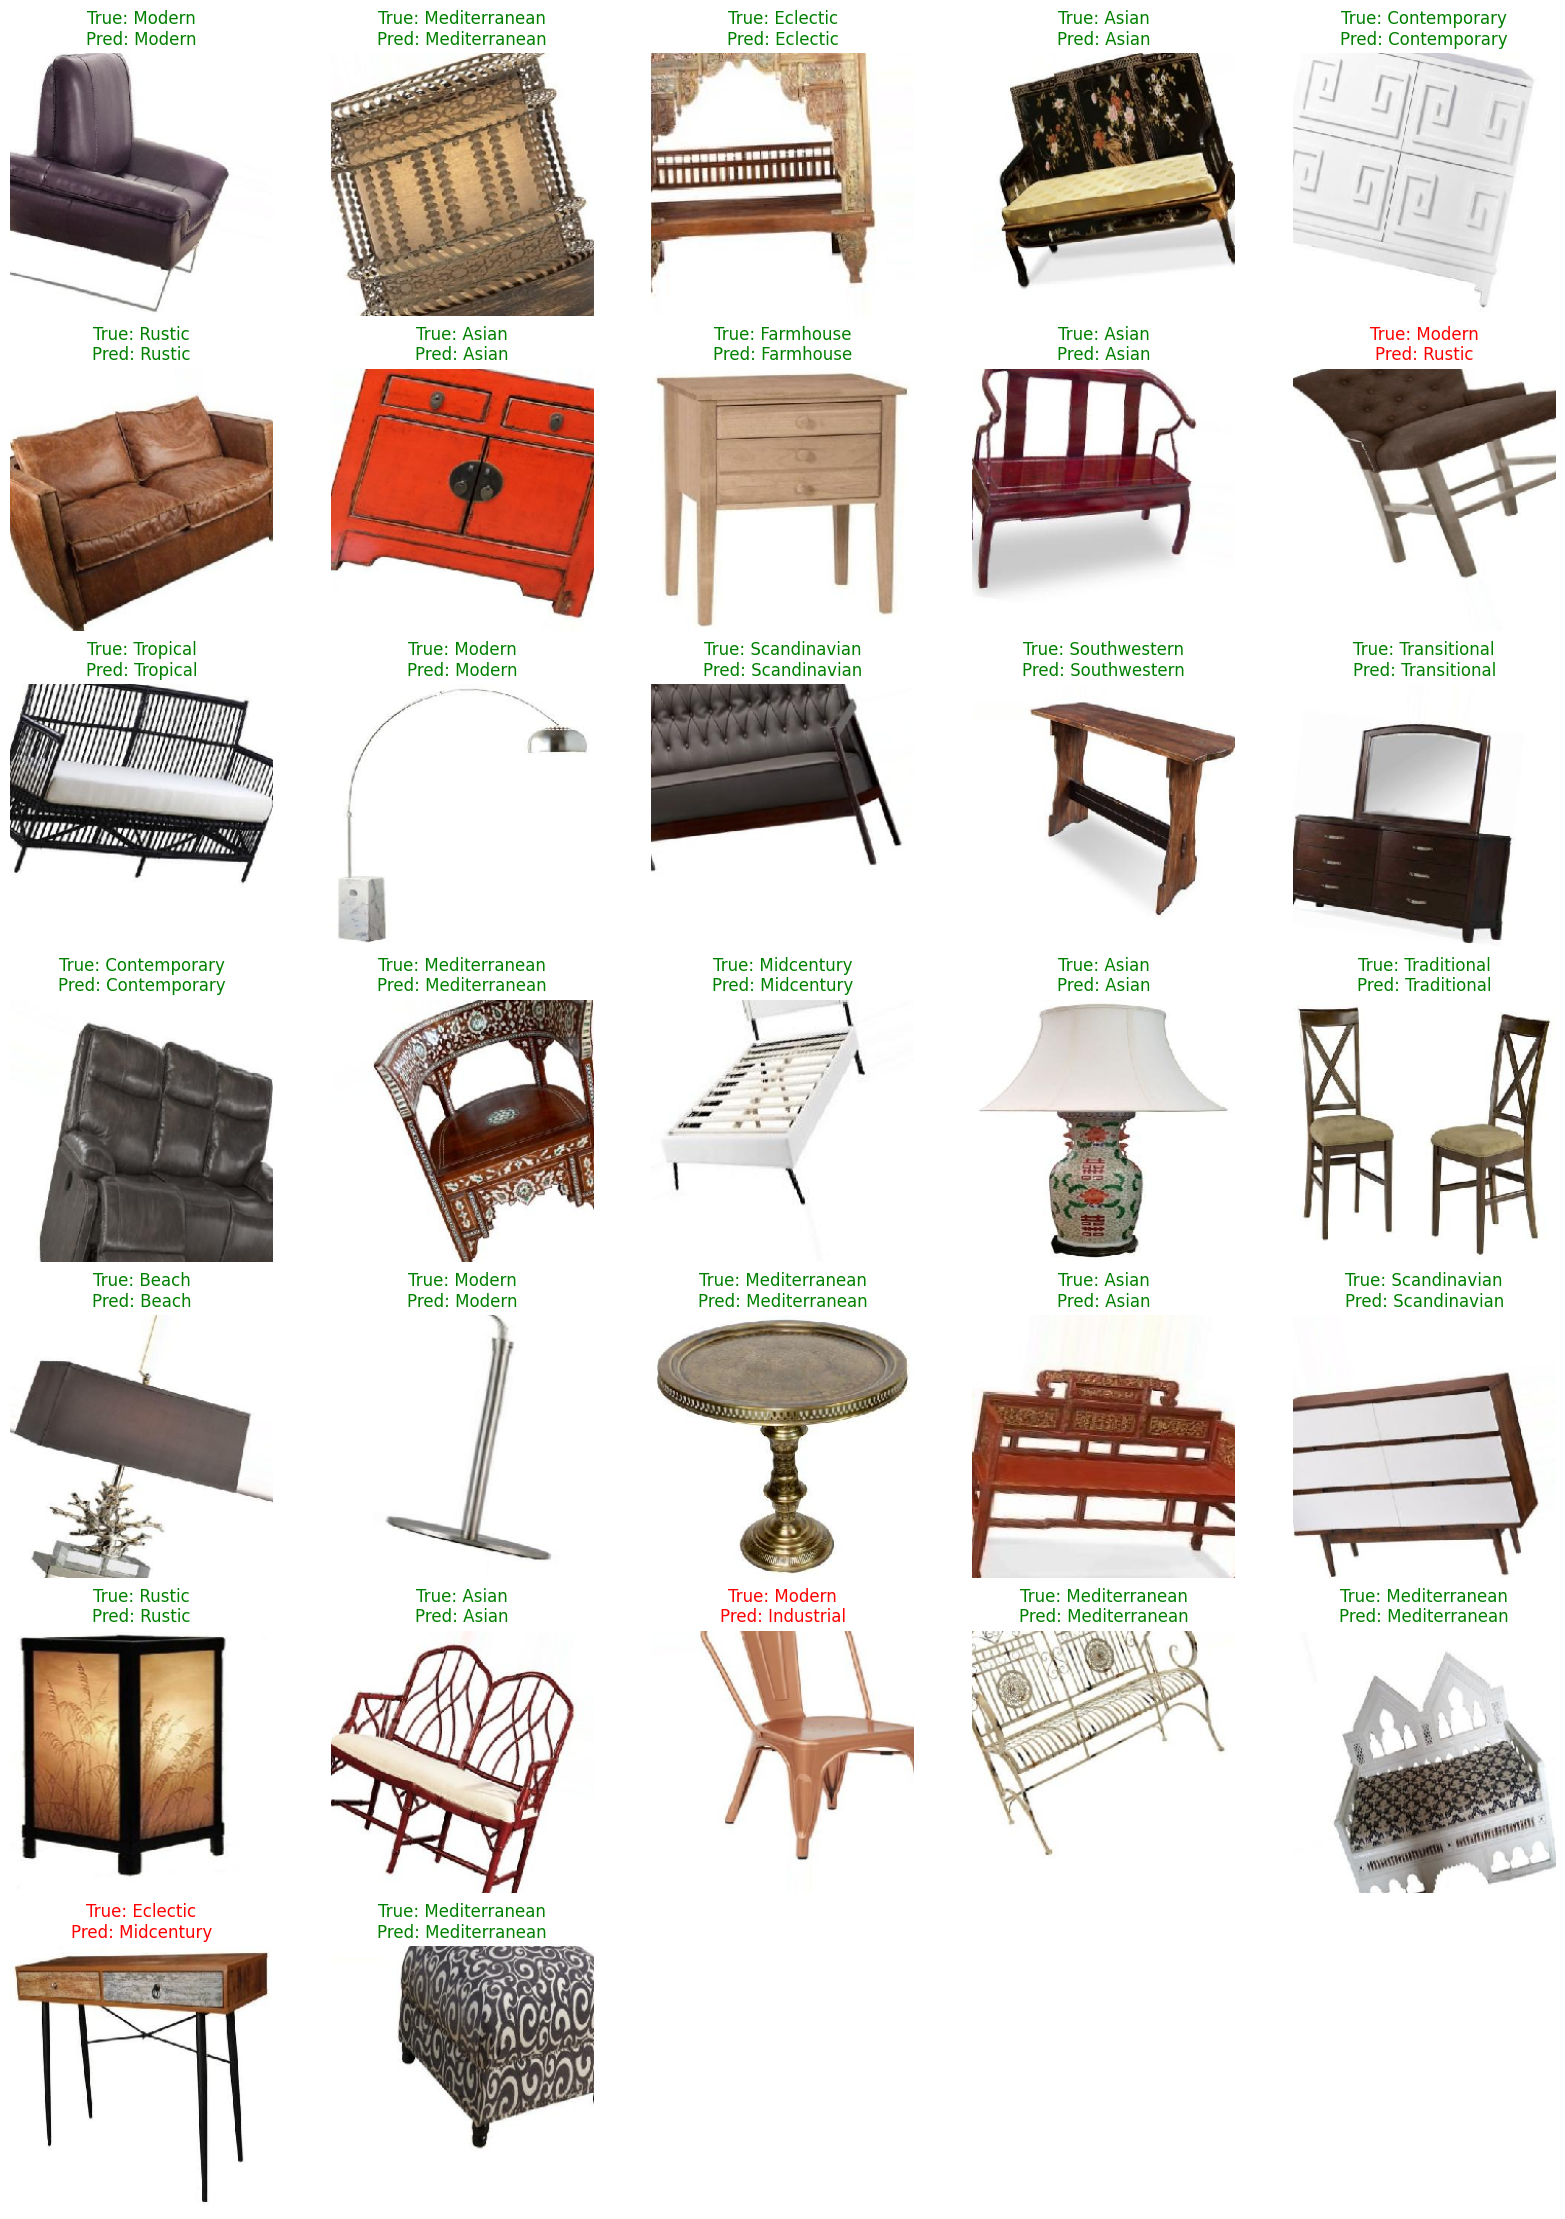

In [26]:
# Display some images with their predictions
def display_predictions(generator, model, num_images=10):
    # Get a batch of data
    x_batch, y_batch = next(generator)

    # Predict the classes
    predictions = model.predict(x_batch)
    y_pred = np.argmax(predictions, axis=1)
    y_true = np.argmax(y_batch, axis=1)

    num_rows = num_images // 5 + (
        1 if num_images % 5 != 0 else 0
    )  # Calculate the number of rows needed
    plt.figure(figsize=(20, 4 * num_rows))  # Set the figure size

    for i in range(num_images):
        plt.subplot(num_rows, min(num_images, 5), i + 1)
        plt.imshow(x_batch[i])

        # Compare individual elements of y_true and y_pred
        if y_true[i] == y_pred[i]:
            color = "green"
        else:
            color = "red"

        label_true = labels[y_true[i]]
        label_pred = labels[y_pred[i]]

        plt.title(f"True: {label_true}\nPred: {label_pred}", color=color)
        plt.axis("off")
    plt.show()

display_predictions(test_dataset_2, resnet_34, num_images=32)

In [21]:
display_predictions(df, resnet_34, num_images=32)

NameError: name 'val_dataset_2' is not defined

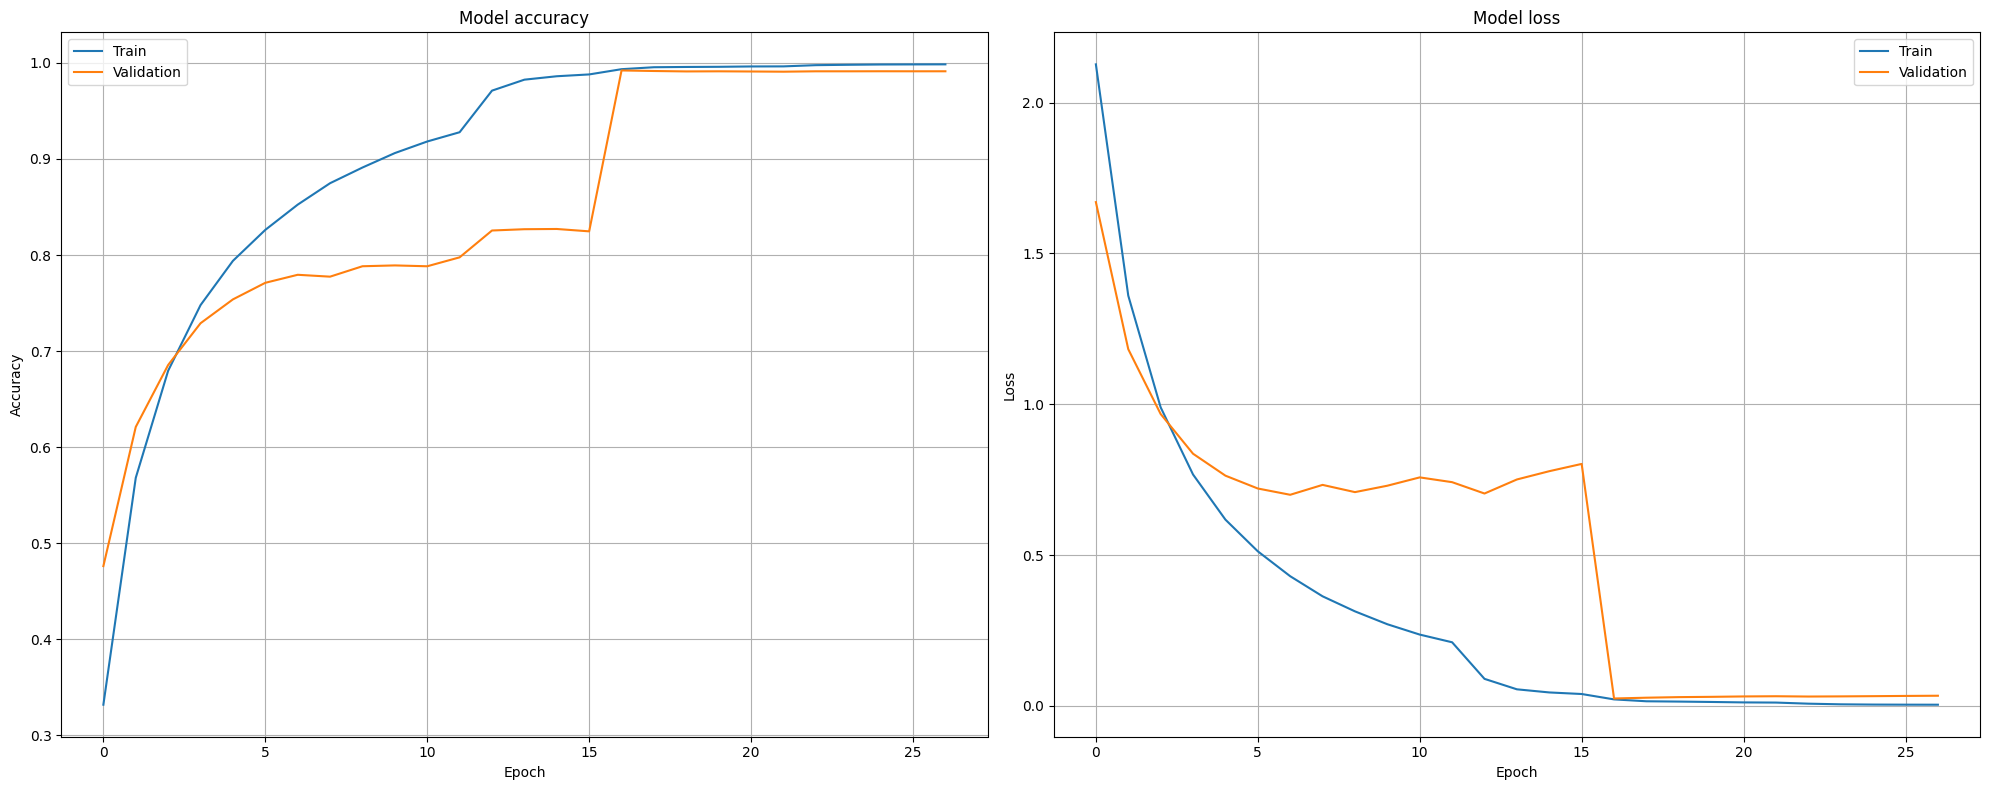

In [27]:
# load saved
saved_history = pd.read_csv("./notebooks/model_development/cache_resnet/training.csv")  # Load training history

# Plot learning curves
def plot_learning_curves(history):
    plt.figure(figsize=(20, 8))  # Set the figure size
    plt.subplot(1, 2, 1)  # First subplot

    # Plot training & validation accuracy values
    plt.plot(history["accuracy"], label="Train")
    plt.plot(history["val_accuracy"], label="Validation")
    plt.title("Model accuracy")  # Title
    plt.ylabel("Accuracy")  # Y label
    plt.xlabel("Epoch")  # X label
    plt.legend()  # Show legend
    plt.grid()  # Show grid

    plt.subplot(1, 2, 2)  # Second subplot

    # Plot training & validation loss values
    plt.plot(history["loss"], label="Train")
    plt.plot(history["val_loss"], label="Validation")
    plt.title("Model loss")  # Title
    plt.ylabel("Loss")  # Y label
    plt.xlabel("Epoch")  # X label
    plt.legend()  # Show legend
    plt.grid()  # Show grid

    plt.tight_layout()  # Tight layout
    plt.show()  # Show plot


plot_learning_curves(saved_history)

Based on our prior analysis, the `ResNet34` model has clearly demonstrated its potential for high accuracy and robust performance in our image recognition task. The exceptional accuracy achieved on the validation set provides strong evidence of the model's ability to generalize effectively to unseen data.

Given this impressive performance, we have concluded that the `ResNet34` model is ready for deployment in real-world scenarios. We will refrain from further fine-tuning or hyperparameter adjustments, as doing so could risk overfitting the model to the training data and unnecessarily consume additional resources.